# Project 3: Deep Learning
## Behavioral Cloning: An End-to-End Deep Learning Steering System

### Overview
The objective of this project was to develop an End-to-End Deep Learning algorithm to clone human driving behavior similar to the one presented by NVidia paper titled [End-to-End Deep Learning for Self Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/). An End-to-End approach only uses a neural network to determine the desired output of a system. For this project, images of a front facing camera mounted on a car were fed to neural network that determined the corresponding steering angle of the a car.

To achieve this, data was collected on a driving simulator that records front camera images and a corresponding steering angle. The camera images were used a training features and steering angles as training labels. The simulator contains two different Tracks. It is important to note that only Track 1 was used to collect training data. After training the neural network, it's performance was validated on Track 1 and the networks's ability to generalize was evaluated on Track 2. The trained network was able to succesfully drive around both tracks without ever leaving the boundaries of the road nor exhibiting 'unsafe' driving behavior.

### Notebook Summary

This jupyter notebook was used to develop the deep learning algorithm to clone driving behavior. The notebook is divided into three major sections:

* **Data Collection and Preparation**: Discusses how data was collected, reviewed, and preprocessed


* **Neural Net Architecture**: Discusses the select architecture and design decisions


* **Training**: Discusses tuning and performance of the selected network



In [2]:
# Import packages
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import keras
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


## Data Collection and Preparation

### Collection Scheme
Driving data was collected over 2 separate recording sessions on **TRACK 1**. The keyboard arrow keys were was used to control the car, but unfortunately produced unreliable steering data. The data recorded was comoposed as follows:

**Data Set 1**: 4 laps of centered driving  

**Data Set 2**: 4 laps of centered driving (*oppossite direction*)

I was to succesfully train the model with this data. Given the poor interface for recording steering data with a simulator, I also decided to use the data set recorded by Udacity using an analog control source where vehicle performance was visibly better. I plotted the histogram of both data sets to compare and contrast their distributions and will discuss it below. An alternative solution was to record data using a console game controller. Many of my peers obtained good data sets with this interface. 

### Loading Data Logs Data
Each data set has an associated ``driving_log.csv`` file that contains the recorded center, left, and right images file paths, throttle, steering angle, and speed. In the real word it is not safe and legally  practical to simulate the off center shifts required to train a car to recuperate of a off center shits. To simulate such behavior the simulator records Left and Right images to represent these off center shifts. To train the vehicle to recuperate from these shifts we assign a correction angle, the angle required for the car to recenter on the road, to each left and right image. The correction angle was empirically selected to be 0.25, and the corresponding steering angles are calculated as follows:

    left image angle = steering angle + 0.25 
    right image angle = steering angle - 0.25

In [3]:
def load_data_logs(PATHS):
    """ Takes in a list of file paths for the recorded training data
        and returns a data frame with the information from all 'drive_log.csv'
        files. Adds 2 additional columns or left and right image steering angle:
        
        left image steer angle = center image steer angle + angle_delta
        right image steer angle = center image steer angle - angle_delta""" 
    
    column_names = ['Center Image','Left Image', 'Right Image',
                'Steering Angle', 'Throttle', 'Break', 'Speed']
    full_data_log = pd.DataFrame(columns=column_names)

    # Load and merge data logs
    for path in PATHS:
        data_log = pd.read_csv(path + 'driving_log.csv')
        data_log.columns = column_names
        data_log['Center Image'] = path + data_log['Center Image'].apply(str.strip)
        data_log['Left Image'] = path + data_log['Left Image'].apply(str.strip)
        data_log['Right Image'] = path + data_log['Right Image'].apply(str.strip)
        full_data_log = pd.concat([full_data_log, data_log])

    # Remove data with no throttle
    full_data_log = full_data_log[full_data_log['Throttle'] > 0].reset_index(drop=True)
    
    # Add left and right image steering angles with corresponding angle correction
    angle_delta = 0.25
    full_data_log['Left Steering Angle'] = full_data_log['Steering Angle'] + angle_delta
    full_data_log['Right Steering Angle'] = full_data_log['Steering Angle'] - angle_delta  
    return full_data_log

In [4]:
PATHS_udacity = ['data/']
PATHS_me = ['data_set_1/', 'data_set_2/']

# Load udacity data sets for training data
full_data_log = load_data_logs(PATHS_udacity)

# Load recorded data sets for comparison
me_data_log = load_data_logs(PATHS_me)

### Print Examples For left center and right image

In [5]:
full_data_log.head()

,Center Image,Left Image,Right Image,Steering Angle,Throttle,Break,Speed,Left Steering Angle,Right Steering Angle
0,data/IMG/center_2016_12_01_13_32_43_357.jpg,data/IMG/left_2016_12_01_13_32_43_357.jpg,data/IMG/right_2016_12_01_13_32_43_357.jpg,0.000000,0.735778,0.0,0.953669,0.250000,-0.250000
1,data/IMG/center_2016_12_01_13_32_43_457.jpg,data/IMG/left_2016_12_01_13_32_43_457.jpg,data/IMG/right_2016_12_01_13_32_43_457.jpg,0.061760,0.985533,0.0,2.124567,0.311760,-0.188240
2,data/IMG/center_2016_12_01_13_32_43_558.jpg,data/IMG/left_2016_12_01_13_32_43_558.jpg,data/IMG/right_2016_12_01_13_32_43_558.jpg,0.052191,0.985533,0.0,3.286475,0.302191,-0.197809
3,data/IMG/center_2016_12_01_13_32_43_659.jpg,data/IMG/left_2016_12_01_13_32_43_659.jpg,data/IMG/right_2016_12_01_13_32_43_659.jpg,0.052191,0.985533,0.0,4.440864,0.302191,-0.197809
4,data/IMG/center_2016_12_01_13_32_43_761.jpg,data/IMG/left_2016_12_01_13_32_43_761.jpg,data/IMG/right_2016_12_01_13_32_43_761.jpg,0.367953,0.985533,0.0,5.565724,0.617953,0.117953


### Initial Data Summary 

In [6]:
total_samples = len(full_data_log)
total_zero_samples = len(full_data_log[full_data_log['Steering Angle']==0])

print("Number of Training Samples:", total_samples)
print("Number of Samples with 0 as steering Angle:", total_zero_samples)
print("Percentage of data with 0 as steering angle:", "{:0.2f}%".format( total_zero_samples/total_samples*100))

Number of Training Samples: 7306
Number of Samples with 0 as steering Angle: 3816
Percentage of data with 0 as steering angle: 52.23%


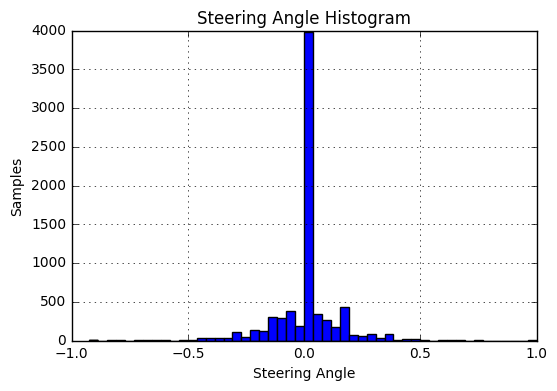

In [7]:
histogram = full_data_log['Steering Angle'].hist(bins=50)
histogram.set_xlabel('Steering Angle')
histogram.set_ylabel('Samples')
histogram.set_title('Steering Angle Histogram')

As seen in the histogram above, there is overwhelming amount of 0's in the data. If left like this, the model will  be biased to predict 0 as a steering angle. A way to combat this is to down sample zero angle samples.

### Down Sampling Zero Data

In [8]:
def resample_zeros(data_set, fraction=0.5): 
    """Return a new data frame with all non-zero angle samples
    concatenated with a random subset of zero angle data.""" 
    data_set_non_zero = data_set[data_set["Steering Angle"] != 0.0]
    data_set_zero = data_set[data_set["Steering Angle"] == 0.0].sample(frac=fraction, random_state= 8809)
    return pd.concat([data_set_non_zero, data_set_zero]).reset_index(drop=True)

# Down sample half of the zero data
re_full_data_log = resample_zeros(full_data_log, 0.40)

# Down sample recorded data to compare to udacity's data
me_data_log = resample_zeros(me_data_log, 0.40)

In [9]:
total_samples = len(re_full_data_log)
total_zero_samples = len(re_full_data_log[re_full_data_log['Steering Angle']==0])

print("Number of Training Samples:", total_samples)
print("Number of Samples with 0 as steering Angle:", total_zero_samples)
print("Percentage of data with 0 as steering angle:", "{:0.2f}%".format( total_zero_samples/total_samples*100))

Number of Training Samples: 5016
Number of Samples with 0 as steering Angle: 1526
Percentage of data with 0 as steering angle: 30.42%


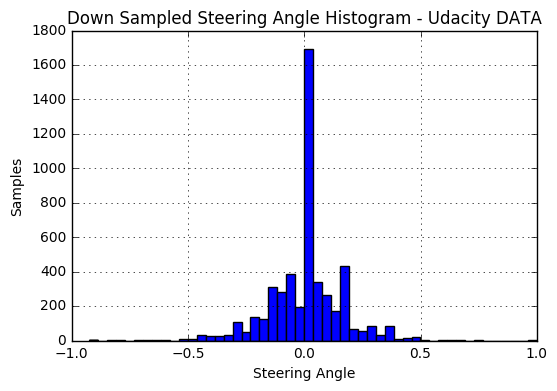

In [10]:
histogram2 = re_full_data_log['Steering Angle'].hist(bins=50)
histogram2.set_xlabel('Steering Angle')
histogram2.set_ylabel('Samples')
histogram2.set_title('Down Sampled Steering Angle Histogram - Udacity DATA')

### Comparison between Udacity and Recorded Data
Udacity data more closely resembles a normal distribution

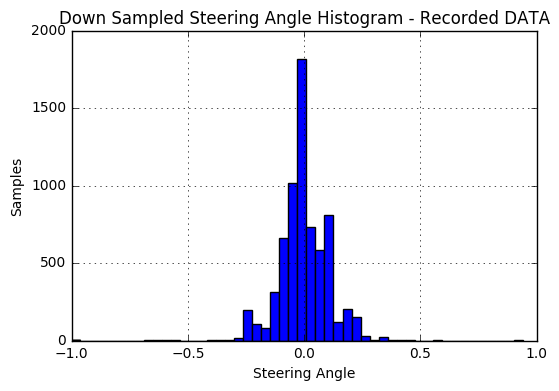

In [11]:
histogram3 = me_data_log['Steering Angle'].hist(bins=50)
histogram3.set_xlabel('Steering Angle')
histogram3.set_ylabel('Samples')
histogram3.set_title('Down Sampled Steering Angle Histogram - Recorded DATA')

## Data Preprocessing and Augmentation
### Color Space Exploration

After reviewing the collected images, there were a few samples that were selected on possibility of the model having trouble recognizing road boundaries. In order to avoid this problem the selection an appropriate color space is key.
For computer vision perception tasks **HSV** and **YUV** color space are usually used since they separte chroma (color) from luma (light). Below I show a comparison of the following color spaces:

1. RGB
2. YUV
3. HSV
6. Grayscale
4. **S-channel in HSV** - selected
5. 1x1x3 convolution: Let's the network figure out the best color space during training

While tuning the architecture, the different color spaces were tested by training the model for a fixed number of epochs and then evaluating their performance in the track. The S-channel in HSV was selected as the input color space for the neural net. The simulator environment is significantly less complex than the real world. Looking at the captured images there aren't many intricate features the net has to learn, which would also increase risk of overfitting the model if a large neural net is used. Interestingly enough, the neural net had a hard time learning to detect the road where boundaries especially in gray scale. It is possible that the reduced amount of features in the simulator made it hard for the distinguish road boundaries. A solution to this would have been to feed more data that shows examples of roads in such conditions. The alternative solution was to only feed the S-channel to the model. As seen below the road is clearly discernable even when crossing the bridge and parts with no clear road fencing.

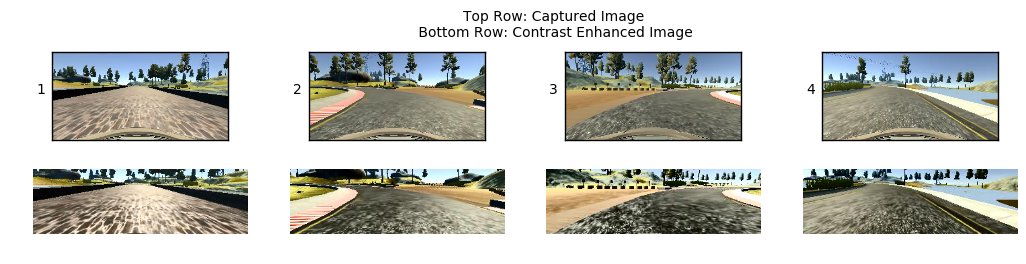

In [12]:
# Plot images that were identified as more likely to cause performance issues for the Neural Net
PATH = 'images_of_interest/'
images_of_interest = os.listdir(PATH)[1:]

title = "Top Row: Captured Image\n Bottom Row: Contrast Enhanced Image"
gs = gridspec.GridSpec(2,len(images_of_interest))
plt.figure(figsize=(16, 2.5)).suptitle(title, y=1.07, x=.45 )
for image, index in zip(images_of_interest, np.arange(0,4)):
    img = cv2.cvtColor(cv2.imread(PATH+image), cv2.COLOR_BGR2RGB)
    # plot original color image
    plt.subplot(gs[index])
    plt.ylabel(index+1, rotation=0, horizontalalignment='right')
    plt.yticks([], [])
    plt.xticks([], [])
    plt.imshow(img)
    
    # plot higher contrast color image
    img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[40:138]
    #img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img= cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
    plt.subplot(gs[index + 5])
    plt.axis('off')
    plt.imshow(img)

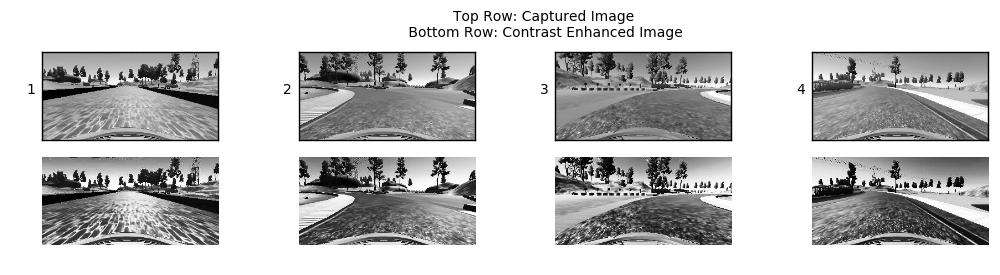

In [13]:
# Plot images that were identified as more likely to cause performance issues for the Neural Net
gs2 = gridspec.GridSpec(2,len(images_of_interest))
title2 = "Top Row: Captured Image in Grayscale \n Bottom Row: Contrast Enhanced Image in Grayscale"
plt.figure(figsize=(16,2.5)).suptitle(title, y=1.07, x=.45 )
for image, index in zip(images_of_interest, np.arange(0,4)):
    img = cv2.cvtColor(cv2.imread(PATH+image), cv2.COLOR_BGR2GRAY)
    # plot original image in grayscale
    plt.subplot(gs2[index])
    plt.imshow(img, cmap='gray')
    plt.ylabel(index+1, rotation=0, horizontalalignment='right')
    plt.yticks([], [])
    plt.xticks([], [])
    
    # plot higher contrast grayscale image
    img = cv2.equalizeHist(img)
    plt.subplot(gs2[index + 5])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

### Data Prepreprocessing

To preprocess the images:

1. **Convert to HSV Color Space and keep S-Channel**
3. **Crop Car Hood and the Horizon**: We want the samples fed to the net to maintly focus on the road.
4. **Resize Image to 64x64**: Since the simulator is much simpler than the real world, reducing the size of the image won't result on loss of important image information and will also be less work for the neural net.

** Note**: Normalization will be done within the neural net!

In [ ]:
def preprocess_image(image, new_col_size, new_row_size):
    """Return a new data frame with all non-zero angle samples
    concatenated with a random subset of zero angle data."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,1]
    image = image[40:138]                               # crop car hood and part of the horizon
    image = cv2.resize(image,(new_row_size, new_col_size), interpolation=cv2.INTER_AREA)
    return image

#### Load Preprocessed Data in Numpy Arrays

In [ ]:
def load_data_from_data_log(data_log, new_row_size=64, new_col_size=64):
    """Return a new data frame with all non-zero angle samples
    concatenated with a random subset of zero angle data."""
    # comments
    num_samples = len(data_log)
    label_data = np.zeros(num_samples*3, dtype=np.float32)
    image_data = np.zeros((num_samples*3, new_row_size, new_col_size), dtype=np.float32)

    # Load center image data
    for index in range(0, num_samples):
        image_c = cv2.imread(data_log['Center Image'][index].strip())
        label_data[index] = data_log['Steering Angle'][index]
        image_data[index] = preprocess_image(image_c, new_row_size, new_col_size)
     
    # Load left image data
    for read_index, write_index in zip(range(num_samples), range(num_samples, num_samples*2)):
        print(data_log['Left Image'][read_index].strip())
        image_l = cv2.imread(data_log['Left Image'][read_index].strip())
        label_data[write_index] = data_log['Left Steering Angle'][read_index]
        image_data[write_index] = preprocess_image(image_l, new_row_size, new_col_size)
    
    # Load right image data
    for read_index, write_index in zip(range(num_samples), range(num_samples*2, num_samples*3)):
        print(data_log['Right Image'][read_index].strip())
        image_r = cv2.imread(data_log['Right Image'][read_index].strip())
        label_data[write_index] = data_log['Right Steering Angle'][read_index]
        image_data[write_index] = preprocess_image(image_r, new_row_size, new_col_size)
        
    # add dimension comment
    image_data = np.reshape(image_data, (image_data.shape[0],new_row_size,
                                                 new_col_size,-1))
    return image_data, label_data

In [ ]:
# Load preprocessed train and test features
train_features, train_labels = load_data_from_data_log(re_full_data_log)

In [ ]:
# Shuffle data
train_features, train_labels = shuffle(train_features, train_labels)
# Create validation set
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.10,
    random_state=832289)

## Display sample image

## A Note on Augmentation

Before augmenting the images I decided to train and test with real data only. I determined that the model did not need any augmentation to succesfully drive in the simulator. I considerd flipping the images along the vertical axis to generate twice the data, but did not see any significant gain in performance both in validation loss and actual driving simulations.

## Neural Net Model Architecture
 The Neural Net used by NVidia in the paper titled [End-to-End Deep Learning for Self Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) consists of 9 layers, including a normalization layer, 5 convolutional layers, and 3 fully connected layers. Given the difference in complexity between the real world and the simulator, a neural net this large (150k + paramters) and deep is not necessary. In addition, having a much larger network than the application needs means more training time, computational complexity, and the extra risk of overfitting.
 
For my neural net architecture I decided to scale down to smaller network, the LeNet architecture. An indeed, LeNet can drive. LeNet has 2 convolutional layers and 2 fully connected layers. Before I used this architecture I made a few changes listed below:

1. **Change the size of the from 32x32 to 64x64**
2. **Added a normalization layer after the input**
3. **Changed the size of the convolution kernels from 5x5 to 3x3**: extract finer features - reducing the number of pixels the filter is sensitive to
4. **Change the activation layers from Relu to ELU(Exponential Linear Units)**: less prone to the vanishing gradient problem
5. **Changed the size of the pooling kernel from 2x2 to 4x4**: Since I changed the size of the input image to 64x64(double the original size) the spacial reduction during the convolution layers with a 2x2 pooling would have yielded a higher number of parameters to tune. Since the features to be extracted simulator are not very complex, I did not want to add additional convolutional layers. By doubling the size of the pooling I was able to achieve the same spacial reduction without increasing the number of hidden layers nor the number of parameters to tune. It is important to be mindful to the fact that larger the pooling kernel the more information is lost from layer to layer, but it is also a way to prevent overfitting and keep our net size small

In addition I tried incorporating ``Batch Normalization`` and ``Dropout`` in my network. Batch normalization significantly speeds up training by dealing with [covariate shift
](http://www.jmlr.org/papers/volume8/sugiyama07a/sugiyama07a.pdf) but resulted in a decline in performance in the simulator. A single training epoch with batch normalization achieved a lower validation loss than 10 epochs without it. My conclusion was that with batch normalization the network was quickly overfitted yielding poor performance. Dropout was also tested, but as concluded in previous projects it is not as effective in smaller networks.

### Architecture - LeNet Drives

#### Input
Accepts a 64x64x1 image as input. S-Channel of HSV color space

----

#### Normalization
Execute image normalization within the neural net.

----

**Layer 1: Convolution.** Filter Size: 3x3. Filter Depth: 6. Output shape should be 62x62x6.

** Elu Activation.** 

**4x4 Max-Pooling.** The output shape should be 15x15x6.


----
**Layer 2: Convolution.** Filter Size: 3x3. Filter Depth: 16. Output shape should be 13x13x16.

** Elu Activation.** 

**4x4 Max-Pooling.** The output shape should be 3x3x16.

----
**Flatten.** Flatten the output of each convolution layer after max-pooling

----
**Layer 4: Fully Connected.** 120 outputs.

** Elu Activation.** 

**Layer 5: Fully Connected.** 84 outputs.

**Relu Activation.**

----

### Output
**Layer 6: Fully Connected (Predicted Anlge).** Steering Angle Value



In [14]:
### Import Keras model layers
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers import Convolution2D, MaxPooling2D, ELU, Flatten
from keras.optimizers import Adam

In [19]:
def LeNet_Drives():
    # model paramaters
    input_shape = (64, 64, 1)
    filter_size = 3
    pool_size = (4,4)
    
    # Create model
    model = Sequential()
    
    # Normalization layer
    model.add(Lambda(lambda x: x/255.-0.5, input_shape=input_shape))
    
    # Convolution 1
    model.add(Convolution2D(6, filter_size, filter_size, init='he_normal', border_mode='valid'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Convolution 2
    model.add(Convolution2D(16, filter_size, filter_size, init='he_normal', border_mode='valid'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=pool_size))
   
   # Flatten
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(120, init='he_normal'))      # fc1
    model.add(ELU())
    #model.add(Dropout(0.5))
    model.add(Dense(84, init='he_normal'))      # fc2
    model.add(ELU())
    #model.add(Dropout(0.5))
    model.add(Dense(1, init='he_normal'))      # output
    return model

In [20]:
model = LeNet_Drives()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 64, 64, 1)     0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 62, 62, 6)     60          lambda_3[0][0]                   
____________________________________________________________________________________________________
elu_9 (ELU)                      (None, 62, 62, 6)     0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 15, 15, 6)     0           elu_9[0][0]                      
___________________________________________________________________________________________

### Training Model

To train the model I chose the following parameters:

1. Learning Rate: 0.001
2. Epochs: 10
3. Loss Function: Mean square error - since our ouput is a single numeric value
4. Batch size: 128

I refrained to use a python generator since the amount of data required to train the network successfuly was small and I did not do any data augmentation, but I am aware of it's usefulness in memory constraint and real time applications.

I was able to train the network on Laptop's CPU. Each training epoch took approximately 10 seconds therefore a total training time of ~1.5 minutes. Training the NVidia network for 10 epochs took approximately 25 minutes.

#### A couple interesting observations

1. Doubling the size of the data by flipping it around the vertical axis did not produce a significant increase in performance
2. Decreasing validation loss was related to performance increase, but an extra epoch or two of training could cause a significant drop in performance due to overfitting(this happend after the 10th epoch)


####  Reflection 
My approach to training the network can be distilled to this: 
- Start simple 
- how much you can push your data before adding augmentation 
- How much you can push your architecture before adding more layers, parameters, or artifacts like batch normalization
- How you can squeeze performance from your training hyperparameters

This project really challenged my intuition on deep learning. Every little detail from data prep to training matters. It is not always the case that augmentation, batch normalization, more data and more filters are beneficial. In most cases these are helpful, but are they really necessary for the task you're trying to achieve? how are they affecting the behaviour of your model? is this architecture optimal for the task at hand?

In [ ]:
# Optimizer - Adam: values represent default settings
adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model
test.compile(optimizer=adam, loss='mse', metric=['accuracy'])

# Train model
history = test.fit(train_features, train_labels,
                    batch_size=128, nb_epoch=10, shuffle=True,
                    validation_data=(valid_features, valid_labels))


### Save Model

In [ ]:
import json
def save_model(model, json_file, weights_file):
    # Save model
    with open(json_file,'w' ) as f:
        json.dump(model.to_json(), f)
    
    # Save weights    
    model.save_weights(weights_file)

In [ ]:
save_model(test,'model.json', 'model.h5')